In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Conv2DTranspose
from keras.layers import Flatten, Reshape, Lambda, Add, Multiply, Layer, InputLayer
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import plot_model
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from time import clock
from IPython.display import SVG
from random import randint, seed
from keras.utils.vis_utils import model_to_dot, plot_model
from sklearn.model_selection import train_test_split
from keras_utils import ModelSaveCallback, TqdmProgressCallback
from matplotlib import gridspec
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
original_dim = (32,32,3)
intermediate_dim = 512
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

In [21]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [22]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [23]:
def variational_autoencoder(original_dim, intermediate_dim, latent_dim):
    
    #Decoder Model
    decoder = Sequential()
    decoder.add(InputLayer(input_shape=(latent_dim,)))
    decoder.add(Dense(intermediate_dim, activation='elu'))
    decoder.add(Reshape(target_shape=(2, 2, 128)))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3,3), activation="elu", strides=2, padding="same"))   
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3,3), activation="elu", strides=2, padding="same"))  
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3,3), activation="elu", strides=2, padding="same"))  
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3,3), strides=2, padding="same"))
    decoder.name = "Decoder_Model"
    
    #Encoder Model
    x = Input(shape=original_dim)

    encoder = (Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="elu"))(x)
    encoder = (MaxPool2D(pool_size=(3,3), padding="same"))(encoder)
    encoder = (Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="elu"))(encoder)
    encoder = (MaxPool2D(pool_size=(3,3), padding="same"))(encoder)
    encoder = (Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="elu"))(encoder)
    encoder = (MaxPool2D(pool_size=(3,3), padding="same"))(encoder)
    encoder = (Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="elu"))(encoder)
    encoder = (MaxPool2D(pool_size=(3, 3), padding="same"))(encoder)
    encoder = (Flatten())(encoder)
    h = Dense(intermediate_dim, activation='relu')(encoder)
    z_mu = Dense(latent_dim, name="Means")(h)
    encoder = Model(x, z_mu)
    
    #Variational Autoencoder
    z_log_var = Dense(latent_dim, name="Std_Deviations")(h)
    z_mu, z_log_var = KLDivergenceLayer(name="KLD")([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)
    eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)), name="Noise")
    z_eps = Multiply()([z_sigma, eps])
    z = Add(name="Resampled_Encoding")([z_mu, z_eps])
    x_pred = decoder(z)
    
    variational_encoder = Model(inputs=[x, eps], outputs=x_pred)
    
    
    return variational_encoder, encoder, decoder

In [24]:
vae, encoder, decoder =  variational_autoencoder(original_dim, intermediate_dim, latent_dim)
vae.compile(optimizer='adam', loss=nll)

In [25]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 11, 11, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 11, 11, 64)   18496       max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

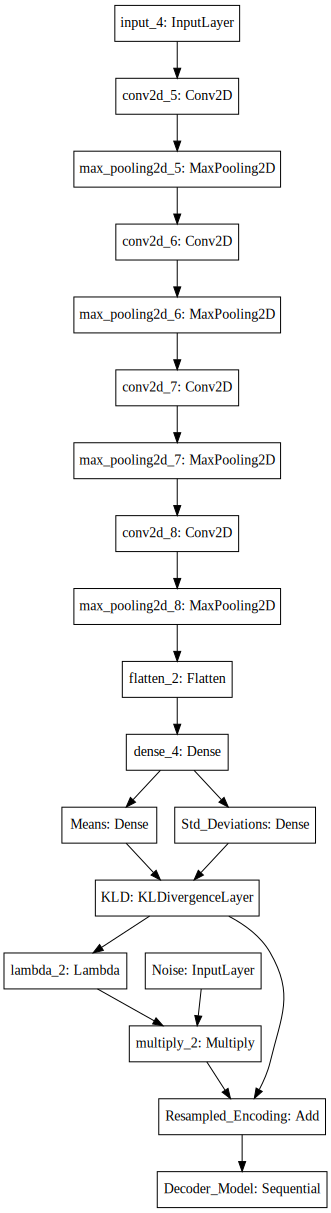

In [26]:
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [27]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

In [28]:
vae.fit(x=x_train, 
        y=x_train,
        epochs = 50,
        validation_data=[x_test, x_test],
        verbose = 1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 342us/step - loss: 2.2937 - val_loss: 2.0805
Epoch 2/50
50000/50000 [==============================] - 17s 337us/step - loss: 2.0756 - val_loss: 2.0741
Epoch 3/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0721 - val_loss: 2.0711
Epoch 4/50
50000/50000 [==============================] - 16s 328us/step - loss: 2.0709 - val_loss: 2.0698
Epoch 5/50
50000/50000 [==============================] - 16s 326us/step - loss: 2.0703 - val_loss: 2.0699
Epoch 6/50
50000/50000 [==============================] - 16s 328us/step - loss: 2.0697 - val_loss: 2.0697
Epoch 7/50
50000/50000 [==============================] - 16s 328us/step - loss: 2.0693 - val_loss: 2.0695
Epoch 8/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0692 - val_loss: 2.0694
Epoch 9/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0692 - val_

In [15]:
#vae.save_weights("vae-test2.h5")
#vae.load_weights("vae-test2.h5")

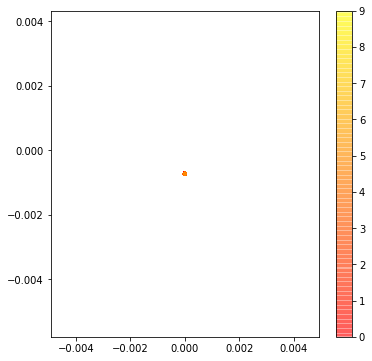

In [16]:
if latent_dim == 2:
    z_test = encoder.predict(x_test, batch_size=100)
    plt.figure(figsize=(6, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=np.squeeze(y_test), alpha=.4, s=3**2, cmap='autumn')
    plt.colorbar()
    plt.show()

In [30]:
# display a 2D manifold of the digits
n = 15  # figure with 10x10 images
digit_size = 32

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.1, .2, n),
                               np.linspace(0.1, .2, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size,3)

plt.rcParams["figure.figsize"] = 20,20

for i in range(n):
    for j in range(n):
        plt.subplot(n,n,n*i + j+1)
        plt.imshow(x_decoded[i][j])
        plt.axis("off")